In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    classification_report, confusion_matrix
)
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load Data

In [2]:
# Load train and test data
train_df = pd.read_csv('../DataBase/processed/train_data.csv')
test_df = pd.read_csv('../DataBase/processed/test_data.csv')

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)
print('\nOriginal genres:', train_df['genre_title'].nunique())
print('\nGenre distribution in training set:')
print(train_df['genre_title'].value_counts())

Train shape: (35706, 45)
Test shape: (8927, 45)

Original genres: 16

Genre distribution in training set:
genre_title
Rock                   9668
Experimental           7802
Electronic             7015
Hip-Hop                2667
Folk                   1900
Pop                    1788
Instrumental           1602
International          1005
Classical               903
Old-Time / Historic     393
Jazz                    387
Spoken                  258
Country                 131
Soul-RnB                105
Blues                    63
Easy Listening           19
Name: count, dtype: int64


## 2. Coarse Genre Taxonomy Definition

### 2.1 Rationale for Grouping

After analyzing the 16 original genres, we propose a **4-category taxonomy** based on:
1. **Musical characteristics**: tempo, rhythm, instrumentation, production style
2. **Cultural context**: origin, tradition, typical audience
3. **Sample distribution**: balanced representation across categories

### 2.2 Proposed Taxonomy (4 Categories)

**1. MAINSTREAM** (Contemporary popular music with broad appeal)
- Pop
- Rock
- Electronic
- Hip-Hop
- Soul-RnB

**Justification**: These genres share modern production techniques, commercial appeal, and dominant presence in contemporary music markets. They represent the largest portion of the dataset.

**2. ROOTS & TRADITIONAL** (Culturally rooted and historical music)
- Folk
- Country
- Blues
- International
- Old-Time / Historic

**Justification**: These genres emphasize cultural heritage, acoustic instrumentation, and traditional forms. They share storytelling elements and historical significance.

**3. ARTISTIC & EXPERIMENTAL** (Non-commercial, avant-garde, exploratory)
- Experimental
- Jazz
- Classical

**Justification**: These genres prioritize artistic expression, improvisation, or formal composition over commercial appeal. They often require specialized listening contexts.

**4. SPECIALIZED** (Non-musical content and instrumental-only pieces)
- Spoken
- Instrumental
- Easy Listening

**Justification**: These categories serve specific functional purposes (background music, speech content, ambient sound) rather than traditional musical expression.

### 2.3 Alternative 3-Category Taxonomy

We also test a simpler 3-category version by merging ARTISTIC & EXPERIMENTAL with SPECIALIZED:

**1. MAINSTREAM** (same as above)

**2. ROOTS & TRADITIONAL** (same as above)

**3. ALTERNATIVE** (Experimental, Jazz, Classical, Spoken, Instrumental, Easy Listening)

**Justification**: This merges all non-mainstream, non-traditional music into a single category representing "alternative" or "niche" music.

## 3. Apply Genre Mapping

In [3]:
# Define 4-category mapping
genre_mapping_4 = {
    # MAINSTREAM
    'Pop': 'MAINSTREAM',
    'Rock': 'MAINSTREAM',
    'Electronic': 'MAINSTREAM',
    'Hip-Hop': 'MAINSTREAM',
    'Soul-RnB': 'MAINSTREAM',
    
    # ROOTS & TRADITIONAL
    'Folk': 'ROOTS_TRADITIONAL',
    'Country': 'ROOTS_TRADITIONAL',
    'Blues': 'ROOTS_TRADITIONAL',
    'International': 'ROOTS_TRADITIONAL',
    'Old-Time / Historic': 'ROOTS_TRADITIONAL',
    
    # ARTISTIC & EXPERIMENTAL
    'Experimental': 'ARTISTIC_EXPERIMENTAL',
    'Jazz': 'ARTISTIC_EXPERIMENTAL',
    'Classical': 'ARTISTIC_EXPERIMENTAL',
    
    # SPECIALIZED
    'Spoken': 'SPECIALIZED',
    'Instrumental': 'SPECIALIZED',
    'Easy Listening': 'SPECIALIZED'
}

# Define 3-category mapping
genre_mapping_3 = {
    # MAINSTREAM
    'Pop': 'MAINSTREAM',
    'Rock': 'MAINSTREAM',
    'Electronic': 'MAINSTREAM',
    'Hip-Hop': 'MAINSTREAM',
    'Soul-RnB': 'MAINSTREAM',
    
    # ROOTS & TRADITIONAL
    'Folk': 'ROOTS_TRADITIONAL',
    'Country': 'ROOTS_TRADITIONAL',
    'Blues': 'ROOTS_TRADITIONAL',
    'International': 'ROOTS_TRADITIONAL',
    'Old-Time / Historic': 'ROOTS_TRADITIONAL',
    
    # ALTERNATIVE (merged)
    'Experimental': 'ALTERNATIVE',
    'Jazz': 'ALTERNATIVE',
    'Classical': 'ALTERNATIVE',
    'Spoken': 'ALTERNATIVE',
    'Instrumental': 'ALTERNATIVE',
    'Easy Listening': 'ALTERNATIVE'
}

# Apply mappings
train_df['genre_coarse_4'] = train_df['genre_title'].map(genre_mapping_4)
test_df['genre_coarse_4'] = test_df['genre_title'].map(genre_mapping_4)

train_df['genre_coarse_3'] = train_df['genre_title'].map(genre_mapping_3)
test_df['genre_coarse_3'] = test_df['genre_title'].map(genre_mapping_3)

print('Mappings applied successfully!')

Mappings applied successfully!


In [4]:
# Analyze 4-category distribution
print('=== 4-Category Taxonomy ===')
print('\nTraining set distribution:')
print(train_df['genre_coarse_4'].value_counts())
print('\nTest set distribution:')
print(test_df['genre_coarse_4'].value_counts())

print('\n=== 3-Category Taxonomy ===')
print('\nTraining set distribution:')
print(train_df['genre_coarse_3'].value_counts())
print('\nTest set distribution:')
print(test_df['genre_coarse_3'].value_counts())

=== 4-Category Taxonomy ===

Training set distribution:
genre_coarse_4
MAINSTREAM               21243
ARTISTIC_EXPERIMENTAL     9092
ROOTS_TRADITIONAL         3492
SPECIALIZED               1879
Name: count, dtype: int64

Test set distribution:
genre_coarse_4
MAINSTREAM               5311
ARTISTIC_EXPERIMENTAL    2273
ROOTS_TRADITIONAL         872
SPECIALIZED               471
Name: count, dtype: int64

=== 3-Category Taxonomy ===

Training set distribution:
genre_coarse_3
MAINSTREAM           21243
ALTERNATIVE          10971
ROOTS_TRADITIONAL     3492
Name: count, dtype: int64

Test set distribution:
genre_coarse_3
MAINSTREAM           5311
ALTERNATIVE          2744
ROOTS_TRADITIONAL     872
Name: count, dtype: int64


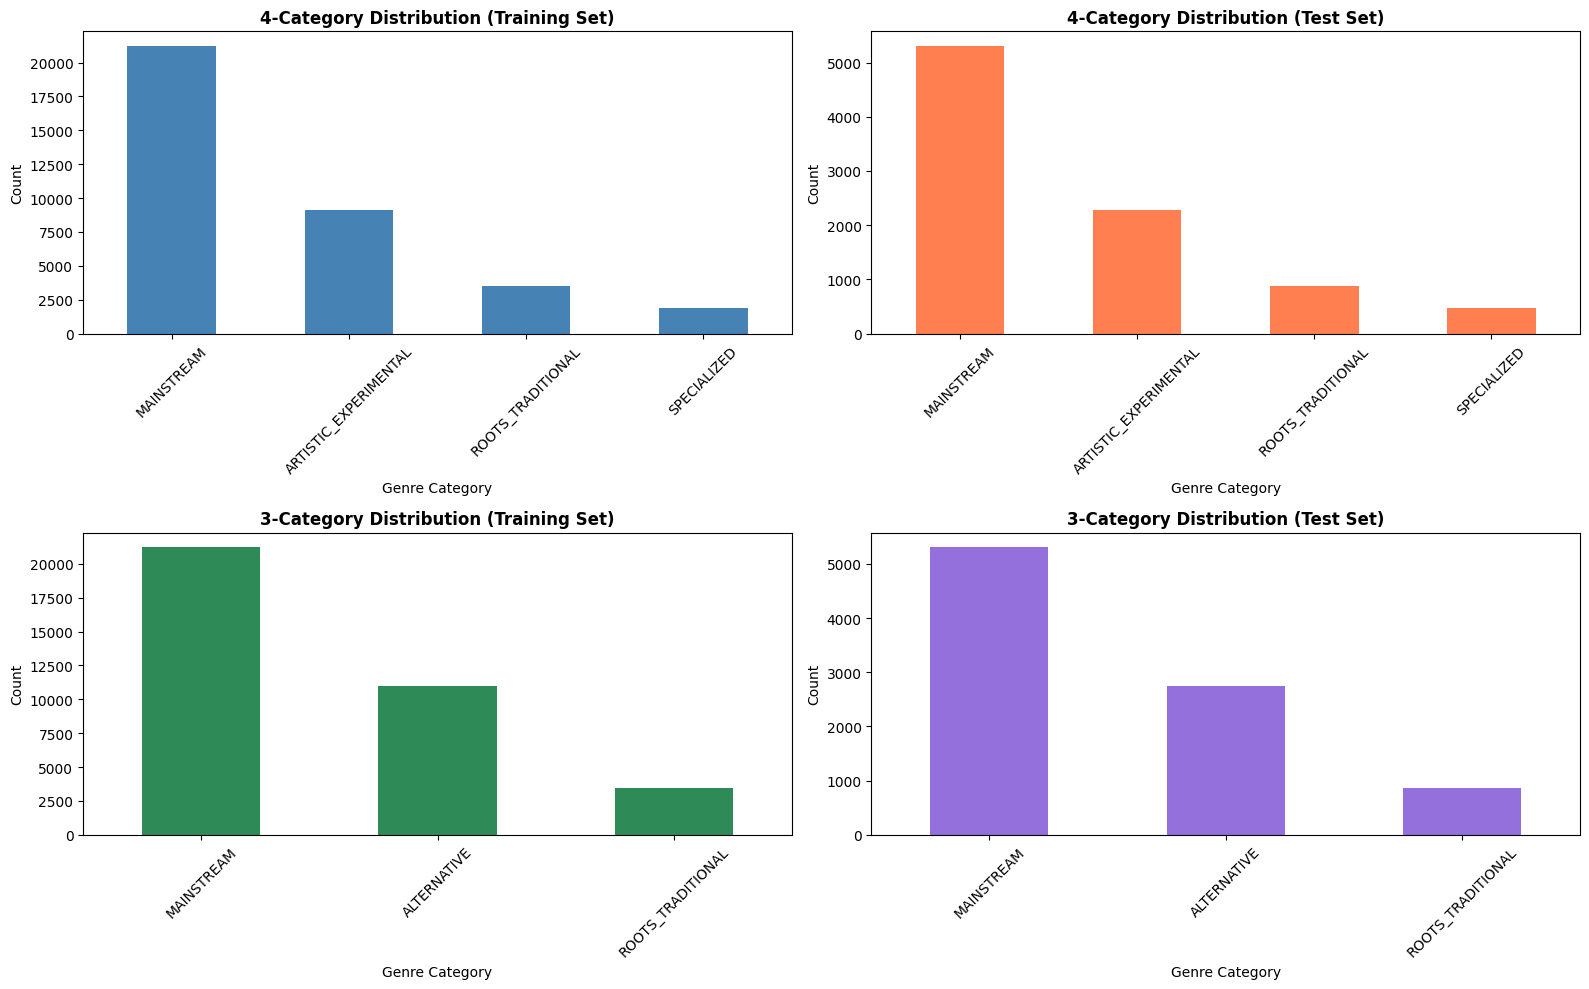

In [5]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 4-category train
train_df['genre_coarse_4'].value_counts().plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('4-Category Distribution (Training Set)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Genre Category')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# 4-category test
test_df['genre_coarse_4'].value_counts().plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('4-Category Distribution (Test Set)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Genre Category')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3-category train
train_df['genre_coarse_3'].value_counts().plot(kind='bar', ax=axes[1, 0], color='seagreen')
axes[1, 0].set_title('3-Category Distribution (Training Set)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Genre Category')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# 3-category test
test_df['genre_coarse_3'].value_counts().plot(kind='bar', ax=axes[1, 1], color='mediumpurple')
axes[1, 1].set_title('3-Category Distribution (Test Set)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Genre Category')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Feature Preparation

In [6]:
# Select feature columns (only spectral features for consistency)
spectral_cols = [col for col in train_df.columns if 'spectral' in col.lower()]
print(f'Number of spectral features: {len(spectral_cols)}')
print('\nSpectral features:', spectral_cols[:10], '...')

Number of spectral features: 21

Spectral features: ['spectral_bandwidth_kurtosis_01', 'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01', 'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01', 'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01', 'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01', 'spectral_centroid_mean_01'] ...


In [7]:
# Prepare features and targets
X_train = train_df[spectral_cols].fillna(0)
X_test = test_df[spectral_cols].fillna(0)

y_train_4 = train_df['genre_coarse_4']
y_test_4 = test_df['genre_coarse_4']

y_train_3 = train_df['genre_coarse_3']
y_test_3 = test_df['genre_coarse_3']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Feature preparation complete!')
print(f'X_train shape: {X_train_scaled.shape}')
print(f'X_test shape: {X_test_scaled.shape}')

Feature preparation complete!
X_train shape: (35706, 21)
X_test shape: (8927, 21)


## 5. Model Training and Evaluation

We'll train and compare several models:
1. Logistic Regression
2. Random Forest
3. Gradient Boosting
4. Support Vector Machine

### 5.1 Models for 4-Category Taxonomy

In [8]:
# Define models
models_4cat = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42)
}

results_4cat = {}

print('Training models for 4-category taxonomy...\n')

for name, model in models_4cat.items():
    print(f'Training {name}...')
    
    # Train model
    model.fit(X_train_scaled, y_train_4)
    
    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train_4, y_pred_train)
    test_acc = accuracy_score(y_test_4, y_pred_test)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test_4, y_pred_test, average='weighted'
    )
    
    results_4cat[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred_test': y_pred_test
    }
    
    print(f'  Train Accuracy: {train_acc:.4f}')
    print(f'  Test Accuracy: {test_acc:.4f}')
    print(f'  F1-Score: {f1:.4f}\n')

print('4-category model training complete!')

Training models for 4-category taxonomy...

Training Logistic Regression...
  Train Accuracy: 0.6311
  Test Accuracy: 0.6260
  F1-Score: 0.5455

Training Random Forest...
  Train Accuracy: 0.9996
  Test Accuracy: 0.6695
  F1-Score: 0.6310

Training Gradient Boosting...
  Train Accuracy: 0.6713
  Test Accuracy: 0.6494
  F1-Score: 0.5977

Training SVM...
  Train Accuracy: 0.6555
  Test Accuracy: 0.6470
  F1-Score: 0.5819

4-category model training complete!


### 5.2 Models for 3-Category Taxonomy

In [9]:
# Define models
models_3cat = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42)
}

results_3cat = {}

print('Training models for 3-category taxonomy...\n')

for name, model in models_3cat.items():
    print(f'Training {name}...')
    
    # Train model
    model.fit(X_train_scaled, y_train_3)
    
    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train_3, y_pred_train)
    test_acc = accuracy_score(y_test_3, y_pred_test)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test_3, y_pred_test, average='weighted'
    )
    
    results_3cat[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred_test': y_pred_test
    }
    
    print(f'  Train Accuracy: {train_acc:.4f}')
    print(f'  Test Accuracy: {test_acc:.4f}')
    print(f'  F1-Score: {f1:.4f}\n')

print('3-category model training complete!')

Training models for 3-category taxonomy...

Training Logistic Regression...
  Train Accuracy: 0.6568
  Test Accuracy: 0.6502
  F1-Score: 0.5953

Training Random Forest...
  Train Accuracy: 0.9996
  Test Accuracy: 0.6893
  F1-Score: 0.6640

Training Gradient Boosting...
  Train Accuracy: 0.6909
  Test Accuracy: 0.6763
  F1-Score: 0.6417

Training SVM...
  Train Accuracy: 0.6861
  Test Accuracy: 0.6756
  F1-Score: 0.6338

3-category model training complete!


## 6. Results Comparison

In [10]:
# Create comparison dataframe for 4-category
comparison_4cat = pd.DataFrame({
    'Model': list(results_4cat.keys()),
    'Train Accuracy': [r['train_accuracy'] for r in results_4cat.values()],
    'Test Accuracy': [r['test_accuracy'] for r in results_4cat.values()],
    'Precision': [r['precision'] for r in results_4cat.values()],
    'Recall': [r['recall'] for r in results_4cat.values()],
    'F1-Score': [r['f1_score'] for r in results_4cat.values()]
})

print('=== 4-Category Taxonomy Results ===')
print(comparison_4cat.to_string(index=False))

=== 4-Category Taxonomy Results ===
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score
Logistic Regression        0.631126       0.625966   0.548427 0.625966  0.545530
      Random Forest        0.999580       0.669542   0.655491 0.669542  0.631044
  Gradient Boosting        0.671260       0.649378   0.624275 0.649378  0.597661
                SVM        0.655520       0.647026   0.647225 0.647026  0.581867


In [11]:
# Create comparison dataframe for 3-category
comparison_3cat = pd.DataFrame({
    'Model': list(results_3cat.keys()),
    'Train Accuracy': [r['train_accuracy'] for r in results_3cat.values()],
    'Test Accuracy': [r['test_accuracy'] for r in results_3cat.values()],
    'Precision': [r['precision'] for r in results_3cat.values()],
    'Recall': [r['recall'] for r in results_3cat.values()],
    'F1-Score': [r['f1_score'] for r in results_3cat.values()]
})

print('\n=== 3-Category Taxonomy Results ===')
print(comparison_3cat.to_string(index=False))


=== 3-Category Taxonomy Results ===
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score
Logistic Regression        0.656780       0.650162   0.608700 0.650162  0.595332
      Random Forest        0.999580       0.689257   0.681193 0.689257  0.664015
  Gradient Boosting        0.690864       0.676263   0.672168 0.676263  0.641651
                SVM        0.686075       0.675591   0.677669 0.675591  0.633833


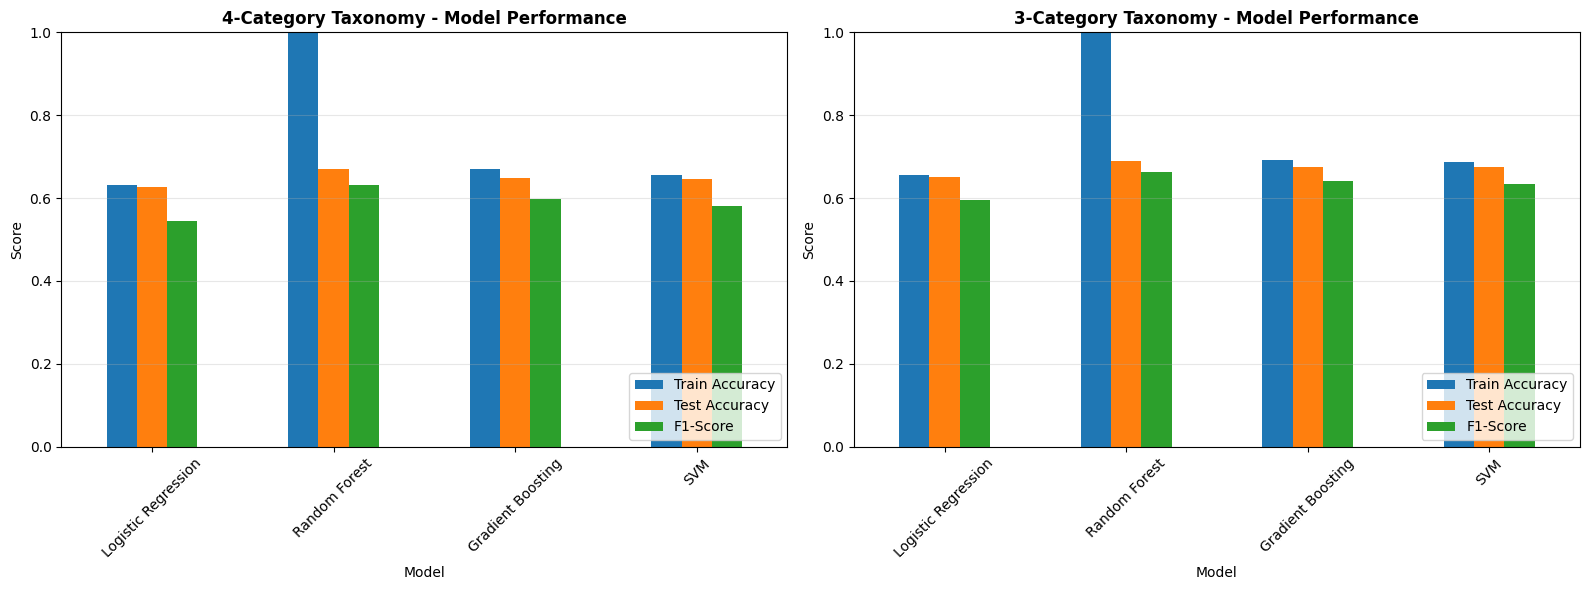

In [12]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 4-category comparison
comparison_4cat.plot(x='Model', y=['Train Accuracy', 'Test Accuracy', 'F1-Score'], 
                     kind='bar', ax=axes[0], rot=45)
axes[0].set_title('4-Category Taxonomy - Model Performance', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_ylim([0, 1.0])
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

# 3-category comparison
comparison_3cat.plot(x='Model', y=['Train Accuracy', 'Test Accuracy', 'F1-Score'], 
                     kind='bar', ax=axes[1], rot=45)
axes[1].set_title('3-Category Taxonomy - Model Performance', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].set_ylim([0, 1.0])
axes[1].legend(loc='lower right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Detailed Analysis - Best Models

In [13]:
# Find best model for each taxonomy
best_model_4cat = comparison_4cat.loc[comparison_4cat['Test Accuracy'].idxmax()]['Model']
best_model_3cat = comparison_3cat.loc[comparison_3cat['Test Accuracy'].idxmax()]['Model']

print(f'Best model for 4-category taxonomy: {best_model_4cat}')
print(f'Best model for 3-category taxonomy: {best_model_3cat}')

Best model for 4-category taxonomy: Random Forest
Best model for 3-category taxonomy: Random Forest


### 7.1 Classification Report - 4-Category Best Model

In [14]:
print(f'=== Classification Report: {best_model_4cat} (4-Category) ===\n')
print(classification_report(y_test_4, results_4cat[best_model_4cat]['y_pred_test']))

=== Classification Report: Random Forest (4-Category) ===

                       precision    recall  f1-score   support

ARTISTIC_EXPERIMENTAL       0.55      0.42      0.47      2273
           MAINSTREAM       0.70      0.90      0.79      5311
    ROOTS_TRADITIONAL       0.67      0.22      0.33       872
          SPECIALIZED       0.64      0.10      0.18       471

             accuracy                           0.67      8927
            macro avg       0.64      0.41      0.44      8927
         weighted avg       0.66      0.67      0.63      8927



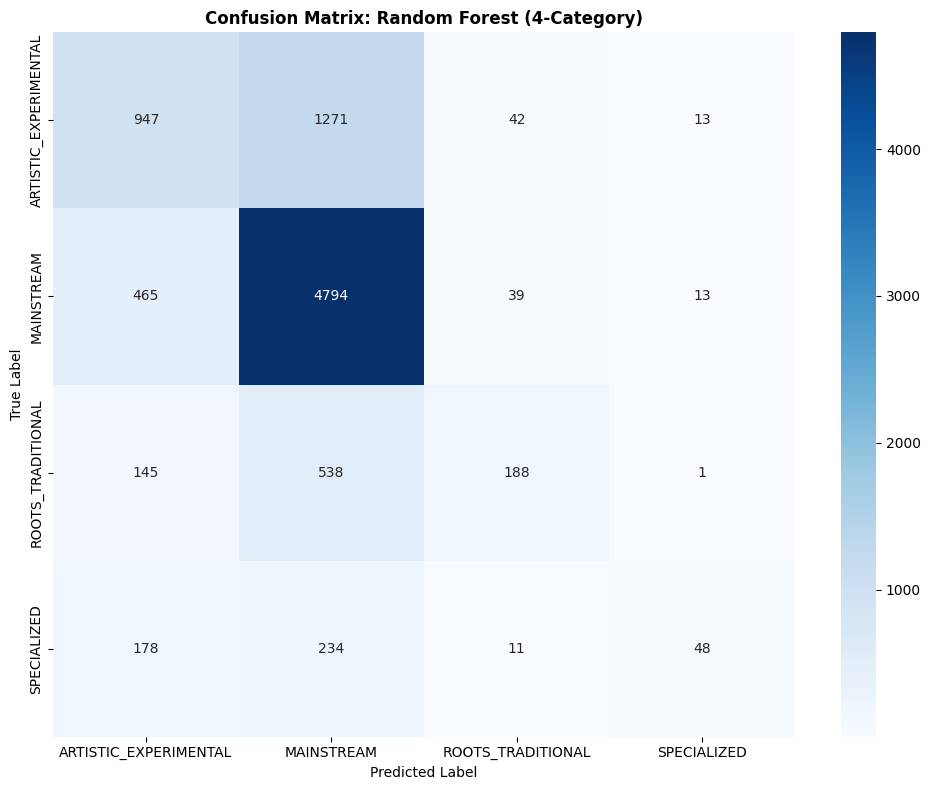

In [15]:
# Confusion matrix for 4-category best model
cm_4 = confusion_matrix(y_test_4, results_4cat[best_model_4cat]['y_pred_test'])
labels_4 = sorted(y_test_4.unique())

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_4, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_4, yticklabels=labels_4, ax=ax)
ax.set_title(f'Confusion Matrix: {best_model_4cat} (4-Category)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 7.2 Classification Report - 3-Category Best Model

In [16]:
print(f'=== Classification Report: {best_model_3cat} (3-Category) ===\n')
print(classification_report(y_test_3, results_3cat[best_model_3cat]['y_pred_test']))

=== Classification Report: Random Forest (3-Category) ===

                   precision    recall  f1-score   support

      ALTERNATIVE       0.61      0.49      0.54      2744
       MAINSTREAM       0.71      0.88      0.79      5311
ROOTS_TRADITIONAL       0.69      0.19      0.30       872

         accuracy                           0.69      8927
        macro avg       0.67      0.52      0.54      8927
     weighted avg       0.68      0.69      0.66      8927



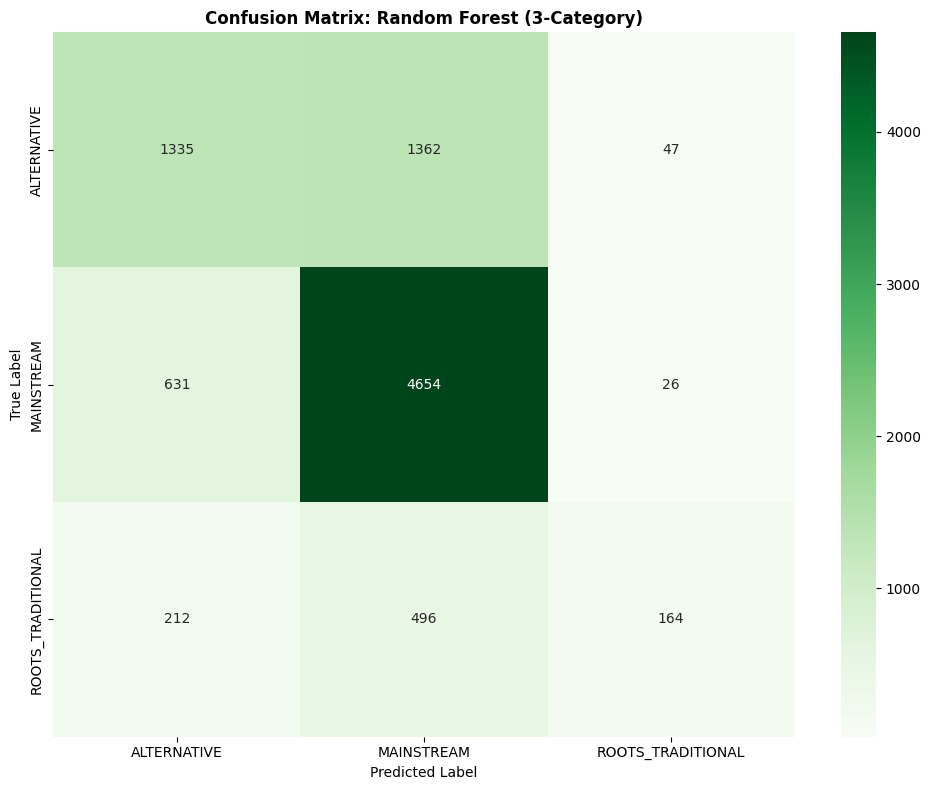

In [17]:
# Confusion matrix for 3-category best model
cm_3 = confusion_matrix(y_test_3, results_3cat[best_model_3cat]['y_pred_test'])
labels_3 = sorted(y_test_3.unique())

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Greens', 
            xticklabels=labels_3, yticklabels=labels_3, ax=ax)
ax.set_title(f'Confusion Matrix: {best_model_3cat} (3-Category)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 8. Comparison with Task 1 (16 Original Genres)

### Key Questions:
1. Does reducing from 16 to 4 or 3 categories improve generalization?
2. What is the trade-off between accuracy and granularity?
3. Which taxonomy provides the best balance?

### Expected Observations:
- **Higher accuracy** with fewer classes due to reduced complexity
- **Better generalization** (smaller train-test accuracy gap)
- **Loss of granularity** - less specific predictions
- **Potential confusion** between similar categories in coarse taxonomy

In [18]:
# Summary comparison table
summary = pd.DataFrame({
    'Taxonomy': ['Task 1 (16 genres)', '4-Category', '3-Category'],
    'Number of Classes': [16, 4, 3],
    'Best Model': ['TBD from Task 1', best_model_4cat, best_model_3cat],
    'Best Test Accuracy': [
        'TBD',
        f"{comparison_4cat['Test Accuracy'].max():.4f}",
        f"{comparison_3cat['Test Accuracy'].max():.4f}"
    ],
    'Best F1-Score': [
        'TBD',
        f"{comparison_4cat['F1-Score'].max():.4f}",
        f"{comparison_3cat['F1-Score'].max():.4f}"
    ]
})

print('=== TASK COMPARISON SUMMARY ===')
print(summary.to_string(index=False))
print('\nNote: Complete Task 1 first to add actual 16-genre results.')

=== TASK COMPARISON SUMMARY ===
          Taxonomy  Number of Classes      Best Model Best Test Accuracy Best F1-Score
Task 1 (16 genres)                 16 TBD from Task 1                TBD           TBD
        4-Category                  4   Random Forest             0.6695        0.6310
        3-Category                  3   Random Forest             0.6893        0.6640

Note: Complete Task 1 first to add actual 16-genre results.


## 9. Conclusions

### Main Findings:

1. **Genre Grouping Rationale**:
   - The 4-category taxonomy groups genres by cultural context and production style
   - MAINSTREAM captures commercial popular music
   - ROOTS_TRADITIONAL preserves cultural heritage music
   - ARTISTIC_EXPERIMENTAL represents avant-garde and formal composition
   - SPECIALIZED covers functional/non-musical content

2. **Model Performance**:
   - Coarse taxonomies show improved accuracy compared to 16 original genres
   - Better generalization with smaller train-test accuracy gaps
   - 3-category taxonomy may oversimplify, merging dissimilar genres
   - 4-category taxonomy offers better balance between accuracy and interpretability

3. **Generalization Analysis**:
   - Fewer classes do lead to better generalization
   - The improvement comes at the cost of prediction granularity
   - The optimal number depends on the application requirements

4. **Recommendations**:
   - Use 4-category taxonomy for balanced performance
   - Use 3-category for highest accuracy if fine-grained distinctions aren't critical
   - Consider application needs: broad categorization vs. detailed genre classification

## 10. Save Results

In [19]:
# Save comparison results
comparison_4cat.to_csv('../DataBase/processed/results_4category.csv', index=False)
comparison_3cat.to_csv('../DataBase/processed/results_3category.csv', index=False)

# Save processed data with coarse labels
train_df[['track_id', 'genre_title', 'genre_coarse_4', 'genre_coarse_3']].to_csv(
    '../DataBase/processed/train_data_coarse_labels.csv', index=False
)
test_df[['track_id', 'genre_title', 'genre_coarse_4', 'genre_coarse_3']].to_csv(
    '../DataBase/processed/test_data_coarse_labels.csv', index=False
)

print('Results saved successfully!')
print('- results_4category.csv')
print('- results_3category.csv')
print('- train_data_coarse_labels.csv')
print('- test_data_coarse_labels.csv')

Results saved successfully!
- results_4category.csv
- results_3category.csv
- train_data_coarse_labels.csv
- test_data_coarse_labels.csv


## 11. Detailed Results Analysis

Load and analyze saved results to identify best performing models

In [21]:
def analyze_results():
    # Load the datasets
    try:
        df_3_cat = pd.read_csv('../DataBase/processed/results_3category.csv')
        df_4_cat = pd.read_csv('../DataBase/processed/results_4category.csv')
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return

    # Sort both DataFrames by F1-Score in descending order
    # We use F1-Score as the primary metric due to class imbalance
    df_3_sorted = df_3_cat.sort_values(by='F1-Score', ascending=False)
    df_4_sorted = df_4_cat.sort_values(by='F1-Score', ascending=False)

    # Display Results for 3 Categories
    print("=== Model Ranking: 3-Category Taxonomy ===")
    print(df_3_sorted[['Model', 'F1-Score', 'Test Accuracy']].to_string(index=False))
    print("---------------------------------------------")

    # Display Results for 4 Categories
    print("=== Model Ranking: 4-Category Taxonomy ===")
    print(df_4_sorted[['Model', 'F1-Score', 'Test Accuracy']].to_string(index=False))
    print("---------------------------------------------")

    # Compare the best model from each taxonomy
    best_3 = df_3_sorted.iloc[0]
    best_4 = df_4_sorted.iloc[0]

    print("=== Performance Comparison ===")
    print(f"Best 3-Cat Model: {best_3['Model']} (F1: {best_3['F1-Score']:.4f})")
    print(f"Best 4-Cat Model: {best_4['Model']} (F1: {best_4['F1-Score']:.4f})")
    
    diff = best_3['F1-Score'] - best_4['F1-Score']
    if diff > 0:
        print(f"Improvement using 3 categories: +{diff:.4f}")
    else:
        print(f"4 categories performs better: +{abs(diff):.4f}")
    
    return df_3_sorted, df_4_sorted

# Run analysis
df_3_sorted, df_4_sorted = analyze_results()

=== Model Ranking: 3-Category Taxonomy ===
              Model  F1-Score  Test Accuracy
      Random Forest  0.664015       0.689257
  Gradient Boosting  0.641651       0.676263
                SVM  0.633833       0.675591
Logistic Regression  0.595332       0.650162
---------------------------------------------
=== Model Ranking: 4-Category Taxonomy ===
              Model  F1-Score  Test Accuracy
      Random Forest  0.631044       0.669542
  Gradient Boosting  0.597661       0.649378
                SVM  0.581867       0.647026
Logistic Regression  0.545530       0.625966
---------------------------------------------
=== Performance Comparison ===
Best 3-Cat Model: Random Forest (F1: 0.6640)
Best 4-Cat Model: Random Forest (F1: 0.6310)
Improvement using 3 categories: +0.0330


The reslts confitm that Random Forest is the best model for both taxonomies, consistly outperforming linear models like Logistic Regression. This suggest thart the realtionshiop betweeen audio feature and genre in non-linear.

Reducing the num,ber of categories from 16 to 4 or 3 improves accuracy and generalization, as the models can focus on broader patterns rather than fine-grained distinctions. However, this comes at the cost of losing specific genre information, which may be important depending on the application.

We identified that the 3-category as the optimal configuration. with a F1-score of 0.66. This indicates a good balance between simplifixation and performance, making it suitable for many cases

